In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
matplotlib.rcParams.update({'font.size': 18})
import numpy as np
from collections import Counter
from operator import itemgetter
import random

# Collaboration Network (undirected)

## Read the network and summary statistics

In [2]:
# read collaboration network as undirected graph from edge list
G_collaboration = nx.read_edgelist('collaboration.edgelist.txt', delimiter="\t",
                                   create_using=nx.Graph())

# print summary of collaboration network
print(nx.info(G_collaboration))

Name: 
Type: Graph
Number of nodes: 23133
Number of edges: 93439
Average degree:   8.0784


In [33]:
G_reddit = pd.read_csv('soc-redditHyperlinks-body.tsv', delimiter="\t")

In [43]:
temp = G_reddit.drop(labels=["POST_ID","TIMESTAMP","PROPERTIES"], axis=1)

In [46]:
G_new_reddit = nx.convert_matrix.from_pandas_edgelist(temp,"SOURCE_SUBREDDIT","TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT")

In [47]:
print(nx.info(G_new_reddit))

Name: 
Type: Graph
Number of nodes: 35776
Number of edges: 124330
Average degree:   6.9505


In [3]:
# An easy way to plot the content of the counters
#I create this function because I will plot a lot of probability distribution functions in this notebook
def plot_counter(counter,xlabel = '',ylabel = '',prob = True,**params):
    lists = sorted(counter.items(), key = itemgetter(1)) # sorted by value
    x, y = zip(*lists) # unpack the list of keys, counts
    p_y = y / np.sum(y) #probability of y
    

    
    if prob:
        y = p_y
    
    plt.clf()
    plt.subplot(121)
    plt.title('Linear Scale')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
    plt.plot(x, y, "ro")

    plt.subplot(122)
    plt.title('Logarithmic Scale')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
    plt.loglog(x, y, "ro")
    
    
    
    if params.get('has_legend',False):
        legend_text = xlabel + ' =' + params['xmeaning'] + '\n' + ylabel + ' =' + params['ymeaning']
        plt.annotate(legend_text, xy=(250, -50), xycoords='axes points',
            size=14, ha='left', va='top',
            bbox=dict(boxstyle='round', fc='w'))
    
    plt.show()

## Degrees, degree histogram and degree distribution

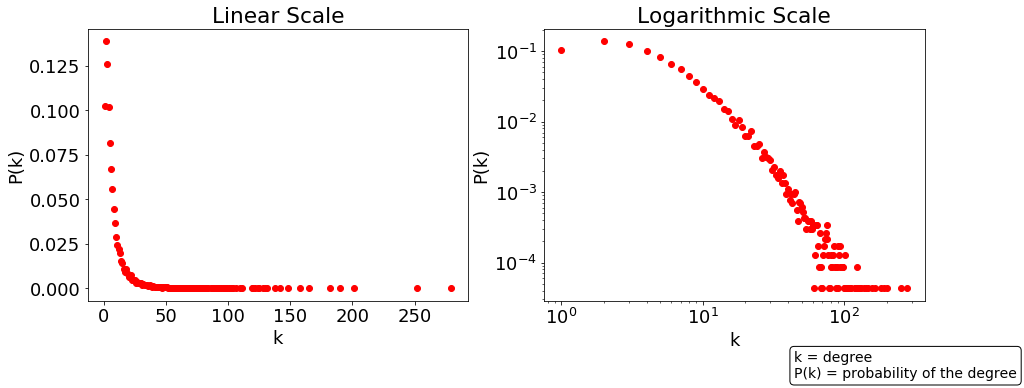

Largest degree of any node in the collaboration network: 279


In [4]:
#this counts the number of nodes with any number of degrees
degree_count = Counter(dict(G_collaboration.degree).values())

plot_counter(degree_count,xlabel =  'k',ylabel ='P(k)',has_legend = True,
             xmeaning = ' degree', ymeaning = ' probability of the degree')
# get the maximum degree of all nodes
print("Largest degree of any node in the collaboration network: {}"
      .format(max([degree for node, degree in G_collaboration.degree()])))

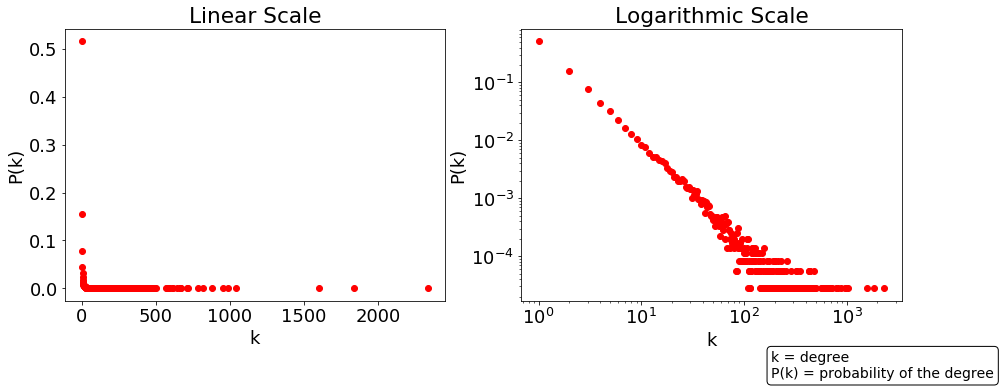

Largest degree of any node in the collaboration network: 2336


In [48]:
degree_count = Counter(dict(G_new_reddit.degree).values())

plot_counter(degree_count,xlabel =  'k',ylabel ='P(k)',has_legend = True,
             xmeaning = ' degree', ymeaning = ' probability of the degree')
# get the maximum degree of all nodes
print("Largest degree of any node in the collaboration network: {}"
      .format(max([degree for node, degree in G_new_reddit.degree()])))

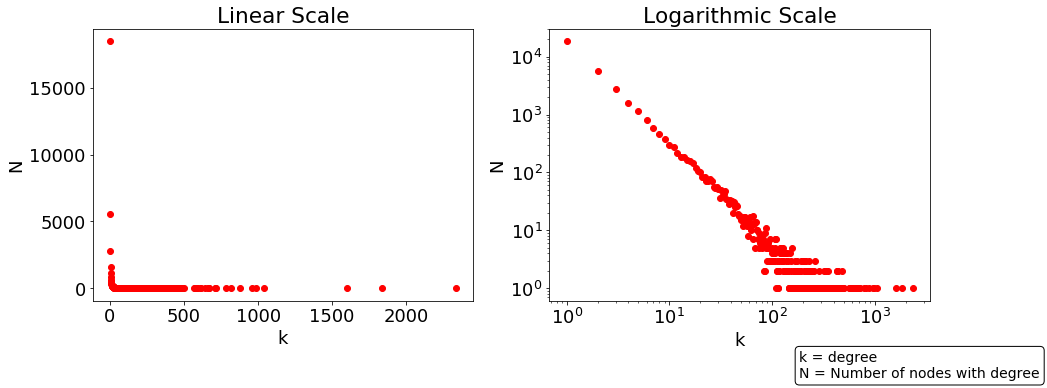

In [50]:
#this counts the number of nodes with any number of degrees
G_collaboration = G_new_reddit
degree_count = Counter(dict(G_collaboration.degree).values())

plot_counter(degree_count,xlabel =  'k',ylabel ='N',prob = False ,has_legend = True,
             xmeaning = ' degree', ymeaning = ' Number of nodes with degree')


## Connected components

In [51]:
ccs = nx.number_connected_components(G_collaboration)
print("The number of components in the network: {}".format(ccs))


The number of components in the network: 497


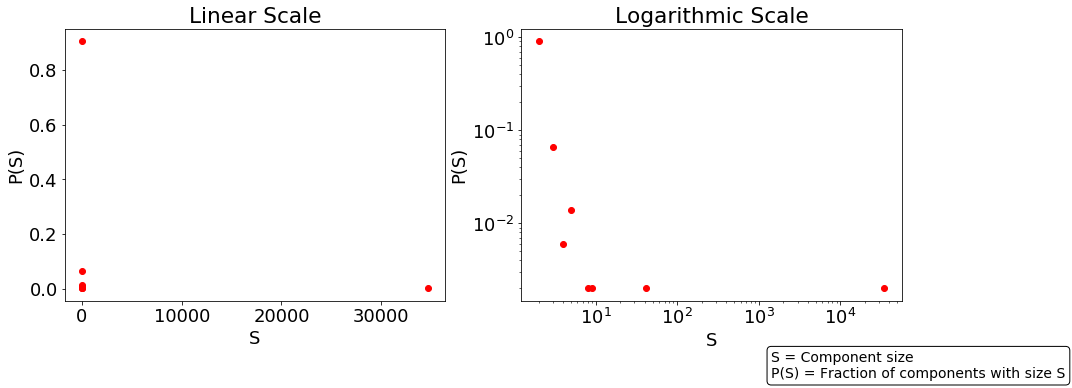

The largest component in the network inculdes 34671 nodes


In [52]:
component_lens = [len(c) for c in nx.connected_components(G_collaboration)]
component_size_count = Counter(component_lens)
plot_counter(component_size_count,xlabel = "S", ylabel = "P(S)",has_legend = True,
             xmeaning = ' Component size', ymeaning = ' Fraction of components with size S')

print("The largest component in the network inculdes {} nodes".format(max(component_size_count.keys())))
# RS: Write or comment somewhere that one cant see anything in the linear plot on the left, and to avoid it in a project.

As you can see the linear scale plot doesn't show a lot of details about the diistribution of the component sizes, so it is better to avoid in this case.

## Clustering coefficient

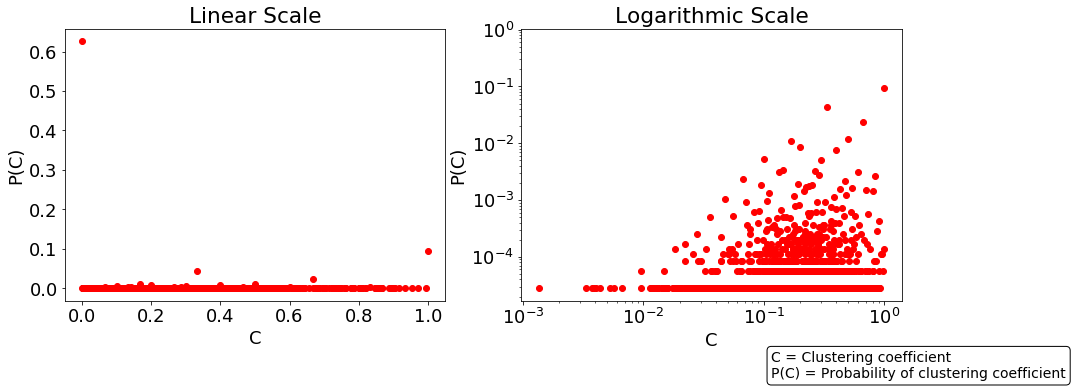

The clustering coefficient of nodes with only one connection is 0 and they are not included on the logarithmic
 scale plot.
The global clustering coefficient of the network: 0.18090101843790804


In [53]:
nodes_clustering = nx.clustering(G_collaboration)
plt.hist(nodes_clustering.values())
clustering_count = Counter(nodes_clustering.values())
plot_counter(clustering_count,xlabel = "C", ylabel = "P(C)" ,has_legend = True,
             xmeaning = ' Clustering coefficient', ymeaning = ' Probability of clustering coefficient')
clustering_coefficient = nx.average_clustering(G_collaboration)
print('The clustering coefficient of nodes with only one connection is 0 and they are not included on the logarithmic\n scale plot.')
print("The global clustering coefficient of the network: {}".format(clustering_coefficient))

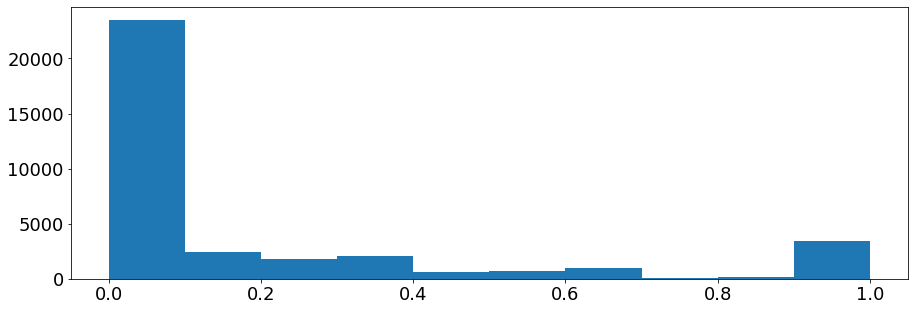

In [58]:
plt.hist(nodes_clustering.values())
plt.show()

## Shortest paths

Calculating all shortest paths in a network is computationally expensive. To be able to measure the shortest paths in a network in reasonable time, I take the largest connected component in the network and sample shortest paths between random pairs. In a large sample of pairs, the distribution of shortest paths approaches that of the whole network. The largest shortest path distance that I sample is not the diameter of the network because I might not sample the two most distiant nodes in the network but it is a good approximation of it.

In [9]:
def get_largest_component(Graph):
    #sorts the connected components and returns the largest one
    components_sorted = sorted( nx.connected_components(Graph) , key=len, reverse=True )
    return Graph.subgraph( components_sorted[0] )

In [10]:
def get_sampled_shortest_path_lens(Graph , number_of_paths = 10000):
    
    path_lens = []
    
    for i in range(number_of_paths):
        
        #if i % 100 == 0:
        #   print(i)
        
        nodes = random.sample(Graph.nodes(),2) # RS: explain that with this you avoid taking the shortest path between a node and itself
        shortest_path = nx.shortest_path(Graph, source=nodes[0], target=nodes[1])
        path_lens.append(len(shortest_path))
    
    return path_lens
    
    

In [11]:
def hist_counter(counter,xlabel = '',ylabel = '',prob = True,**params):
    lists = sorted(counter.items(), key = itemgetter(1)) # sorted by value
    x, y = zip(*lists) # unpack the list of keys, counts
    p_y = y / np.sum(y) #probability of y
    
    if prob:
        y = p_y

    plt.clf()
    plt.subplot(121)
    plt.title('Shortest path distribution')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(1, max(x)+1, 1.0))
    
    if params.get('has_xlim',False):
        plt.xlim(params['left'],params['right'])
        
    plt.bar(x ,y)
    
    if params.get('has_legend',False):
        legend_text = xlabel + ' =' + params['xmeaning'] + '\n' + ylabel + ' =' + params['ymeaning']
        plt.annotate(legend_text, xy=(250, -50), xycoords='axes points',
            size=14, ha='left', va='top',
            bbox=dict(boxstyle='round', fc='w'))

    plt.show()

In [56]:
Collaboration_largest_component = get_largest_component(G_collaboration)
shortest_path_len_counts = Counter(get_sampled_shortest_path_lens(Collaboration_largest_component,number_of_paths = 1000))

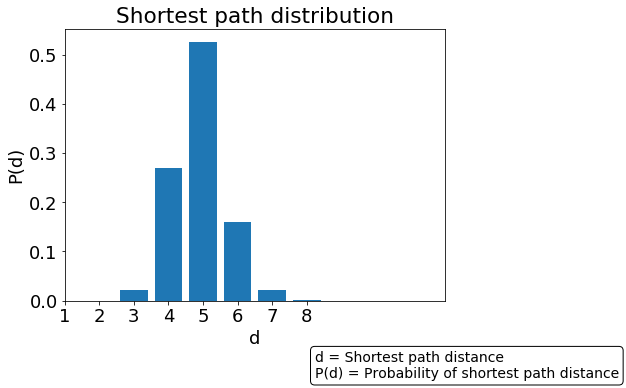

The longest sampled shortest path in the largest connected component of the network is 8 long.


In [57]:

hist_counter(shortest_path_len_counts,ylabel = "P(d)",xlabel = "d",has_legend = True
             ,xmeaning = ' Shortest path distance', ymeaning = ' Probability of shortest path distance',
            has_xlim = True, left = 1, right = 12, xticks=np.arange(0,10,1))

print("The longest sampled shortest path in the largest connected component of the network is {} long."
      .format(max(shortest_path_len_counts.keys()))) 

There are no shortest distances of distance 1 on this plot. This is not because there are no pairs at distance 1 (links!), but because it is unlikely to sample one of these pairs randomly. E.g the probability of getting two nodes at distance 1 is $\frac{2L}{N(N-1)}$, where $L$ is the number of links, and $\frac{N(N-1)}{2}$ the number of possible pairs. In this case it is roughly $10^{-5}$.

# E-mail Network (directed)

## Read the network and summary statistics

In [14]:
# read email network as directed graph from edge list
G_email = nx.read_edgelist('email.edgelist.txt', delimiter="\t",
                           create_using=nx.DiGraph())

# print summary of email network
print(nx.info(G_email))

Name: 
Type: DiGraph
Number of nodes: 57194
Number of edges: 103731
Average in degree:   1.8137
Average out degree:   1.8137


## Degrees, in and out degree distributions

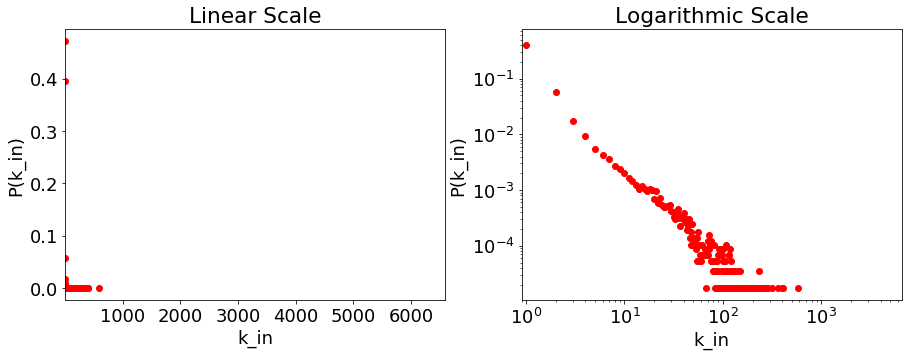

Largest in degree of any node in the collaboration network: 584


In [15]:
in_degree_count = Counter(dict(G_email.in_degree).values())

plot_counter(in_degree_count,xlabel =  'k_in',ylabel ='P(k_in)',
            has_xlim = True, left = 0.9, right = 6600)

print("Largest in degree of any node in the collaboration network: {}"
      .format(max(in_degree_count.keys())))

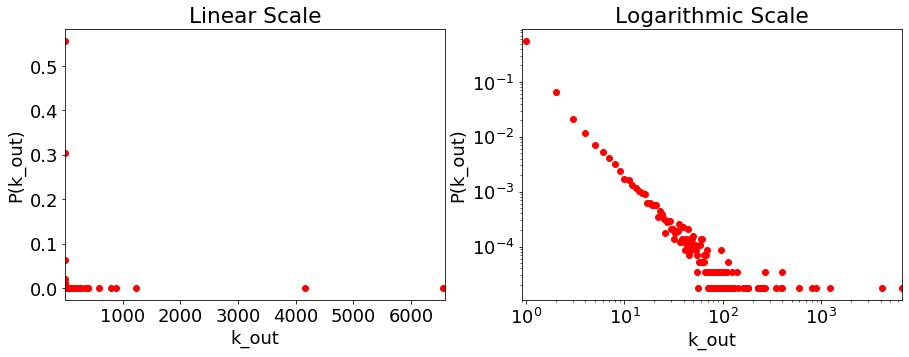

Largest out degree of any node in the collaboration network: 6553


In [16]:
out_degree_count = Counter(dict(G_email.out_degree).values())

plot_counter(out_degree_count,xlabel =  'k_out',ylabel ='P(k_out)',
            has_xlim = True, left = 0.9, right = 6600)
print("Largest out degree of any node in the collaboration network: {}"
      .format(max(out_degree_count.keys())))

## Strongly and weakly connected components

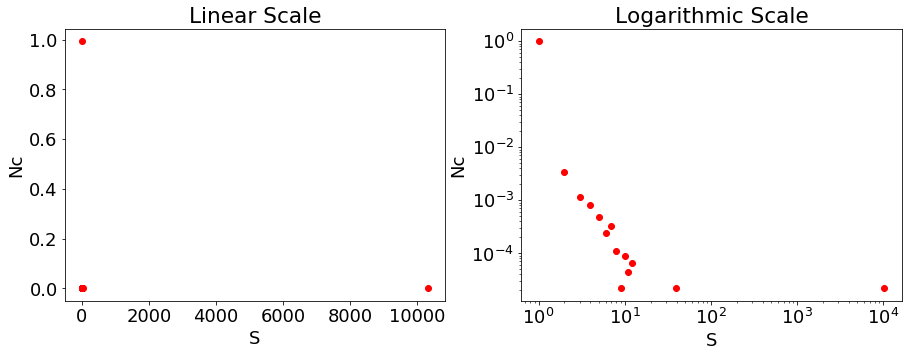

The largest strongly connected component in the network includes 10319 nodes


In [17]:
strong_component_lens = [len(c) for c in nx.strongly_connected_components(G_email)]
strong_component_size_count = Counter(strong_component_lens)
plot_counter(strong_component_size_count,xlabel = 'S', ylabel = 'Nc')
print("The largest strongly connected component in the network includes {} nodes".format(max(strong_component_size_count.keys())))

A weakly connected component in a directed graph is a subgraph 
where all pair of nodes are connected by a shortest path if we do not take into account the direction of the edges. A strongly connected component is a subgraph where you can get from any node to any other node using the edge direction. For example, on the picture below there is one weakly connected component and 3 circled strongly connected component.
![](https://www.startpage.com/av/proxy-image?piurl=https%3A%2F%2Fcdn.programiz.com%2Fsites%2Ftutorial2program%2Ffiles%2Fscc-strongly-connected-components.png&sp=1599051340T5b6ad531cfdfad57c17446912df1b6e97e1455fede8f95f621a9dc0d7f9ce46a)

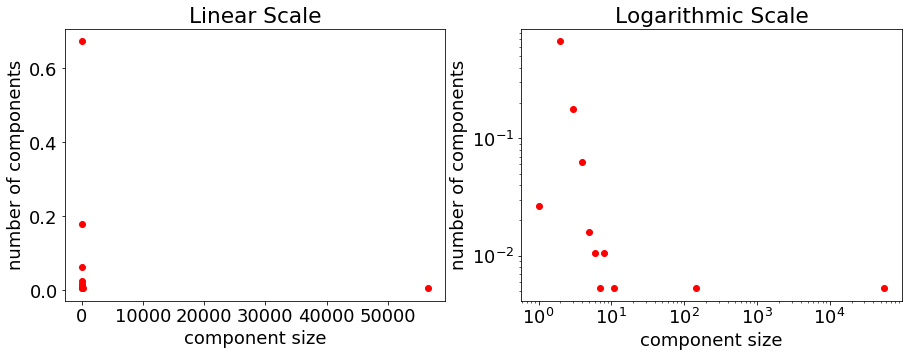

The largest weakly connected component in the network inculdes 56576 nodes


In [18]:
weak_component_lens = [len(c) for c in nx.weakly_connected_components(G_email)]
weak_component_size_count = Counter(weak_component_lens)
plot_counter(weak_component_size_count,xlabel = "component size", ylabel = "number of components")
print("The largest weakly connected component in the network inculdes {} nodes"
      .format(max(weak_component_size_count.keys())))

## Shortest paths

I need to take the largest strongly connected component because this is the only way that I can make sure there is a path between two nodes that I sample
![](https://www.startpage.com/av/proxy-image?piurl=https%3A%2F%2Fcdn.programiz.com%2Fsites%2Ftutorial2program%2Ffiles%2Fscc-strongly-connected-components.png&sp=1598897234Ta1f372fc1fef7ddb2ae1f7b4bc382c1922ccc31c29a2fbc25d19816e132579fc)
This picture is one weakly connected component but only the circled nodes are strongly connected because it is possible to get from any node of the strong component to any other. 

In [19]:
def get_largest_strong_component(DiGraph):
    
    components_sorted = sorted( nx.strongly_connected_components(DiGraph) , key=len, reverse=True )
    return DiGraph.subgraph( components_sorted[0] )

In [20]:
largest_strong_component = get_largest_strong_component(G_email)
shortest_path_len_counts = Counter(get_sampled_shortest_path_lens(largest_strong_component))

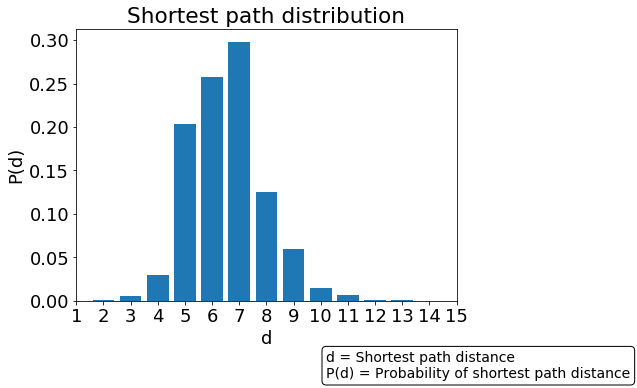

The longest sampled shortest path in the largest connected component of the network is 15 long.


In [21]:

hist_counter(shortest_path_len_counts,ylabel = "P(d)",xlabel = "d",has_legend = True
             ,xmeaning = ' Shortest path distance', ymeaning = ' Probability of shortest path distance',
            has_xlim = True, left = 1, right = 15)

print("The longest sampled shortest path in the largest connected component of the network is {} long."
      .format(max(shortest_path_len_counts.keys()))) 

# Game of Thrones Network (weighted)

## Read the network and summary statistics

In [22]:
G_of_T = nx.Graph()

# open file with node data to ensure that no isolated nodes are disregarded
with open("got-s1-nodes.csv") as file:
    # get the tag and the character name for each character
    for line in file.readlines()[1:]:
        tag, name = line.split(",")
        G_of_T.add_node(tag, name = name)
    
# open edge file to add connections
with open("got-s1-edges.csv") as file:
    # add edge with character interactions as numeric weight attribute 
    for line in file.readlines()[1:]:
        source, target, weight, season = line.split(",")
        G_of_T.add_edge(source, target, weight=int(weight))

print(nx.info(G_of_T))

Name: 
Type: Graph
Number of nodes: 127
Number of edges: 549
Average degree:   8.6457


## Degrees, degree histogram and degree distribution

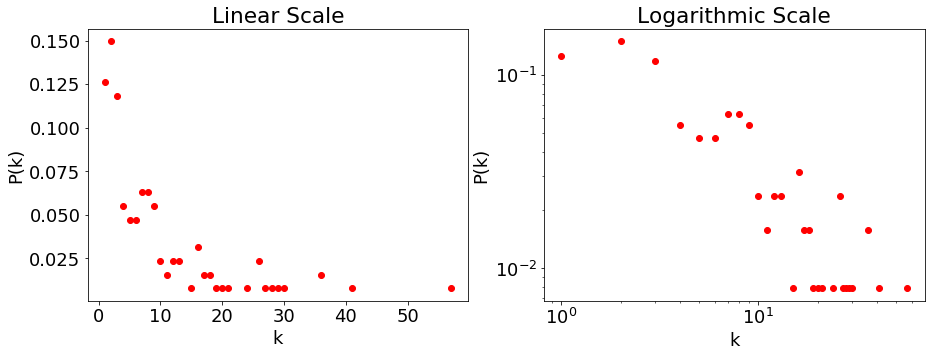

Largest degree of any node in the collaboration network: 279


In [23]:
GOT_degree_count = Counter(dict(G_of_T.degree).values())

plot_counter(GOT_degree_count,xlabel =  'k',ylabel ='P(k)')
# get the maximum degree of all nodes
print("Largest degree of any node in the collaboration network: {}"
      .format(max([degree for node, degree in G_collaboration.degree()])))

## Node strengths

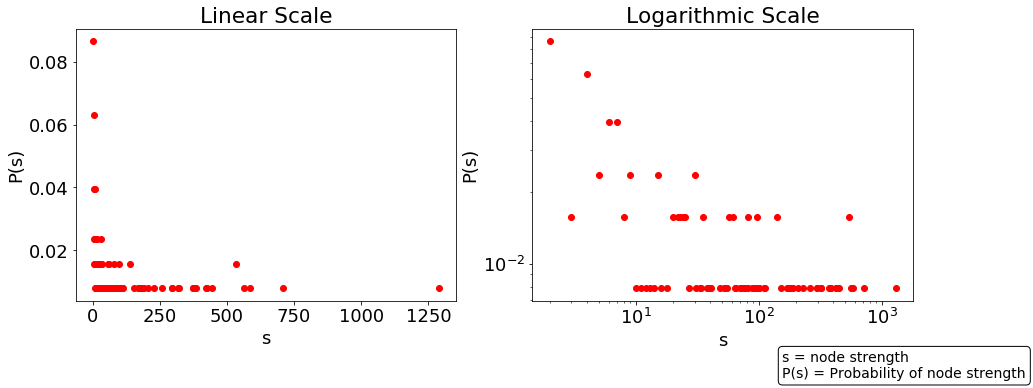

The highest strength nod in the network is 1290


In [24]:
#I create a list of the node strengths here
strengths = []
for node in G_of_T.nodes():
    strength = 0
    for u,v,d in G_of_T.edges(node, data = True):
        strength += d['weight']
    strengths.append(strength)

strength_count = Counter(strengths)
plot_counter(strength_count,xlabel = "s", ylabel = "P(s)" ,has_legend = True,
             xmeaning = ' node strength', ymeaning = ' Probability of node strength')

print("The highest strength nod in the network is {}".format(max(strength_count.keys())))


## Connected components

In [25]:
component_lens = [len(c) for c in nx.connected_components(G_of_T)]
component_size_count = Counter(component_lens)
print("The size of the large component is "+str(max(component_size_count.keys()))+". Because this is equal to the number of total nodes, the network is connected." )

The size of the large component is 127. Because this is equal to the number of total nodes, the network is connected.


## Clustering coefficients

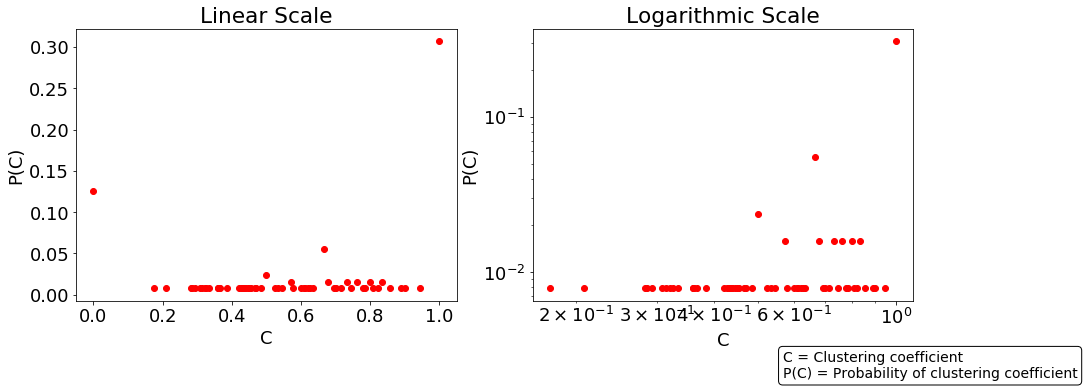

The global clustering coefficient of the network: 0.6292756778605129


In [26]:
nodes_clustering = nx.clustering(G_of_T)
clustering_count = Counter(nodes_clustering.values())
plot_counter(clustering_count,xlabel = "C", ylabel = "P(C)" ,has_legend = True,
             xmeaning = ' Clustering coefficient', ymeaning = ' Probability of clustering coefficient')
clustering_coefficient = nx.average_clustering(G_of_T)
print("The global clustering coefficient of the network: {}".format(clustering_coefficient))


## Edge weights

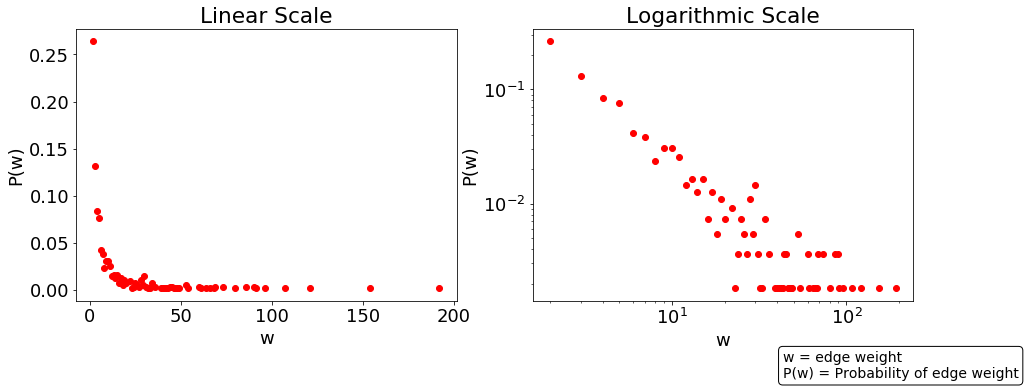

In [27]:
edge_weights = [d['weight'] for u, v, d in G_of_T.edges(data=True)]
weight_count = Counter(edge_weights)
plot_counter(weight_count,ylabel = "P(w)",xlabel = "w",has_legend = True,
             xmeaning = ' edge weight', ymeaning = ' Probability of edge weight')


## Shortest paths

In [28]:
#I set a new attribute to the edges which is the inverse of the weight 
#for the shortest path algorithm so if two characters meet more they are closer to eachother in the network
for u,v,d in G_of_T.edges(data=True):
    d['distance'] = 1/d['weight']

Dijkstra's algorithm is different than the normal shortest path seach beacause it takes into account the weight of the edegs.  

In [29]:
path_lengths = dict(nx.all_pairs_dijkstra_path_length(G_of_T,weight = 'distance'))


In [30]:
shortest_path_lengths = []

for dictionary in path_lengths.values():

    for length in dictionary.values():

        shortest_path_lengths.append(length)
        


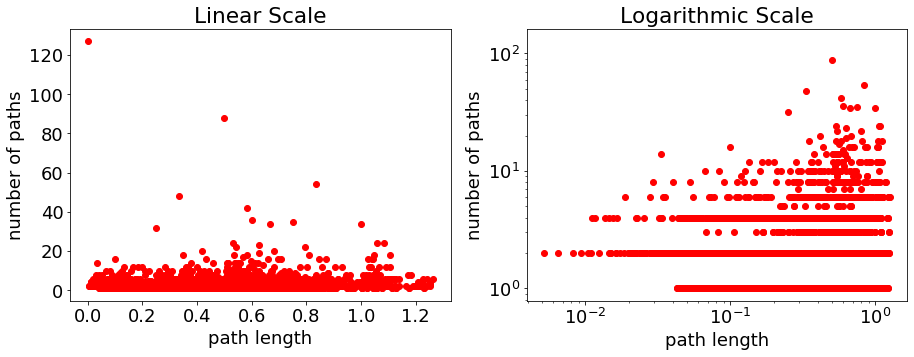

The diameter of the network is 1.264732142857143


In [31]:
shortest_path_len_counts = Counter(shortest_path_lengths)

plot_counter(shortest_path_len_counts,prob = False ,ylabel = "number of paths",xlabel = "path length")

print("The diameter of the network is {}".format(max(shortest_path_len_counts.keys())))

I could calculate the the diameter of the network in this case because I have all the shortest paths and the diameter is simply the longest one of these.

# What do you need to do?
* Familiarize with the different measures and plots. 
* Then use your favorite dataset (one you want to explore, or the one of your project), and measure the same quantities. Remember to identify the kind of network first, and use the appropriate measures
* You can adapt the provided code or write your own, using your programming style. 
* Make sure that you look closely at the plots, and that you can interpret them.
* If you don't have a favorite network yet, use the phonecalls network uploaded to learnIT as 'phonecalls.edgelist.txt'.It is an undirected un weighted network. Nodes represent a sample of cell phone users, they are connected if they have called each other at least once during the observed period. More about the research with this data set is on this link: https://www.researchgate.net/publication/41486426_Limits_of_Predictability_in_Human_Mobility

## Food for thought 
* Why are there no shortest paths of length 1 in the shortest path distribution plot? How many should there be if you were able to measure the shortest path between all pairs of nodes?
* Why do the shortest paths plots look so different in the collaboration and GoT networks? 
* Why is there no clustering coefficient measurement for the email network?
* When we measure the clustering coefficient for GoT, which information are we disregarding which could be potentially useful in the concept of clustering?
* Why don't we calculate the diameter for the collaboration and email networks?
